In [11]:
import pandas as pd
import numpy as np
import pickle
from sqlalchemy import create_engine
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from gensim.models import Word2Vec
import umap
import plotly.graph_objs as go

# Load Word2Vector model.

In [2]:
with open('/Users/jamoth/DSR/DataScienceJobs/Pickles/word2vec.pkl','rb') as file:
    w2v_model = pickle.load(file)

In [3]:
w2v_model.wv.most_similar(positive='python')

[('r', 0.7332905530929565),
 ('sql', 0.6941978931427002),
 ('pythonr', 0.6459277868270874),
 ('scala', 0.6067802906036377),
 ('java', 0.588568925857544),
 ('using', 0.5873699188232422),
 ('pythonexperience', 0.5774579048156738),
 ('programming', 0.5640395879745483),
 ('scripting', 0.5516290664672852),
 ('matlab', 0.5400223731994629)]

In [8]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    sns.set_style("darkgrid")
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=21).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    #plt.xlim(Y[:, 0].min(), Y[:, 0].max())
    #plt.ylim(Y[:, 1].min(), Y[:, 1].max())
            
    plt.title('tSNE visualization for {}'.format(word.title()))

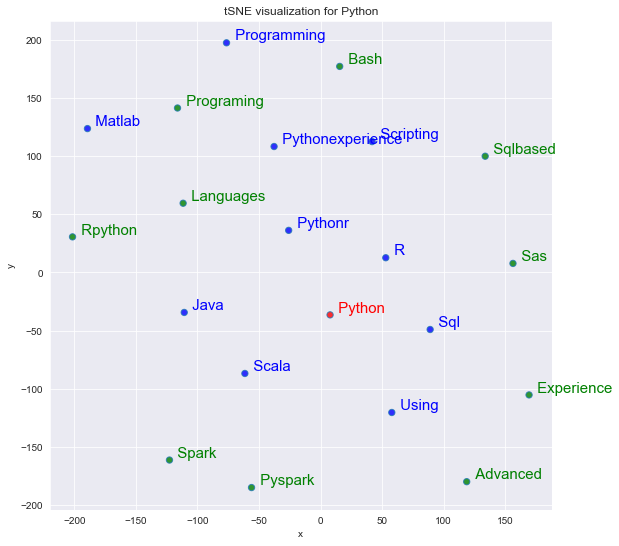

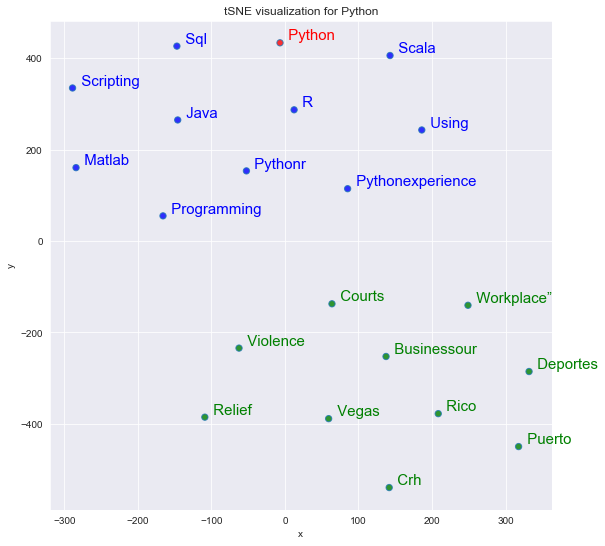

In [9]:
# Plots 10 closest word (blue) and the 11th- 20th closest words (green)
tsnescatterplot(w2v_model, "python", [t[0] for t in w2v_model.wv.most_similar(positive=["python"], topn=20)][10:])

# Plots 10 closest word (blue) and the 10 most distant words (green)
tsnescatterplot(w2v_model, 'python', [i[0] for i in w2v_model.wv.most_similar(negative=["python"])])

In [47]:
def umapscatterplot(model, word, list_names):
    """ Plot in seaborn the results from the UMAP dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    sns.set_style("darkgrid")
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['blue']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('red')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    #reduc = PCA(n_components=21).fit_transform(arrays)
    
    Y = umap.UMAP(n_components=2, random_state=0).fit_transform(arrays) #reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    red = df.loc[df['color']=='red']
    blue = df.loc[df['color']=='blue']
    green = df.loc[df['color']=='green']
    
    # Traces
    trace0 = dict(type='scatter', x=red.x, y=red.y, mode = 'markers', marker = dict(color=red.color), name = 'far words', text=red.words, textposition='top center')
    trace1 = dict(type='scatter', x=blue.x, y=blue.y, mode = 'markers', marker = dict(color=blue.color), name = 'searched word: '+ word, text=blue.words, textposition='top center')
    trace2 = dict(type='scatter', x=green.x, y=green.y, mode = 'markers', marker = dict(color=green.color), name = 'close words' , text=green.words, textposition='top center')


    # Layout
    layout = dict(title='UMAP visualization for: {}'.format(word), xaxis=dict(title=''),yaxis=dict(title=''), width=600, height=400)
    
    # Figure
    fig = go.Figure(data=[trace0, trace1, trace2], layout=layout) 
    fig.update_traces(textposition='top center')

    fig.show(config=dict(displaylogo=False,editable=True))
    
    #fig = px.scatter(df, x='x', y='y', text='words', width=800, height=400) # hover_over=['words']
    #fig.update_traces(textposition='top center')
    #fig.show()

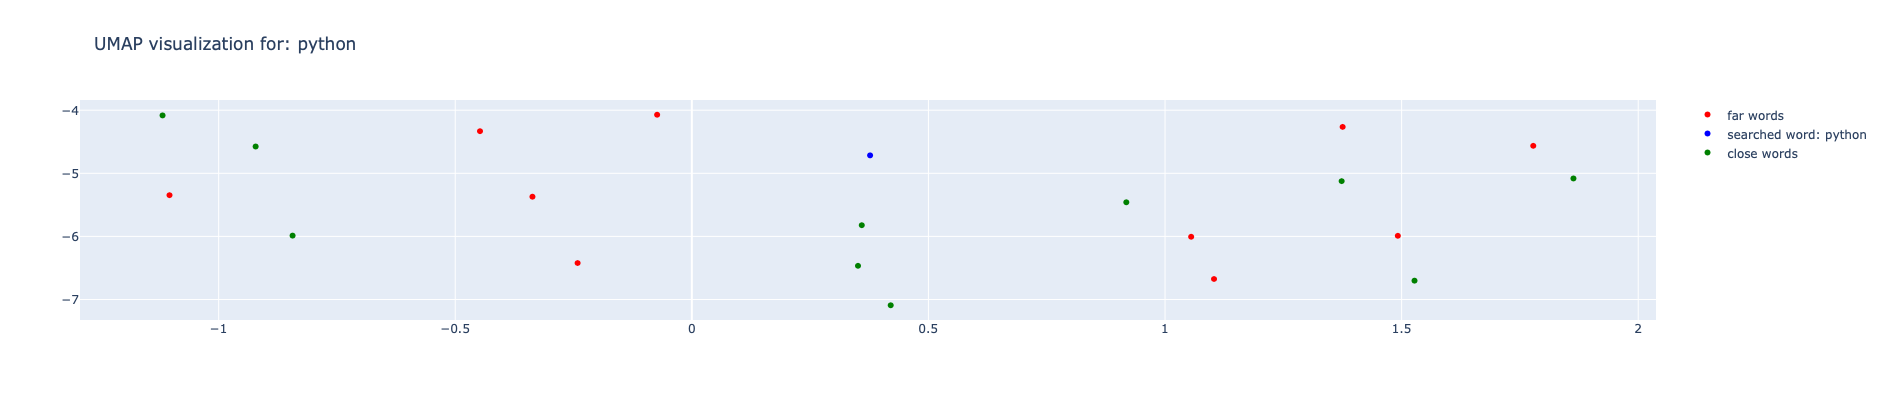

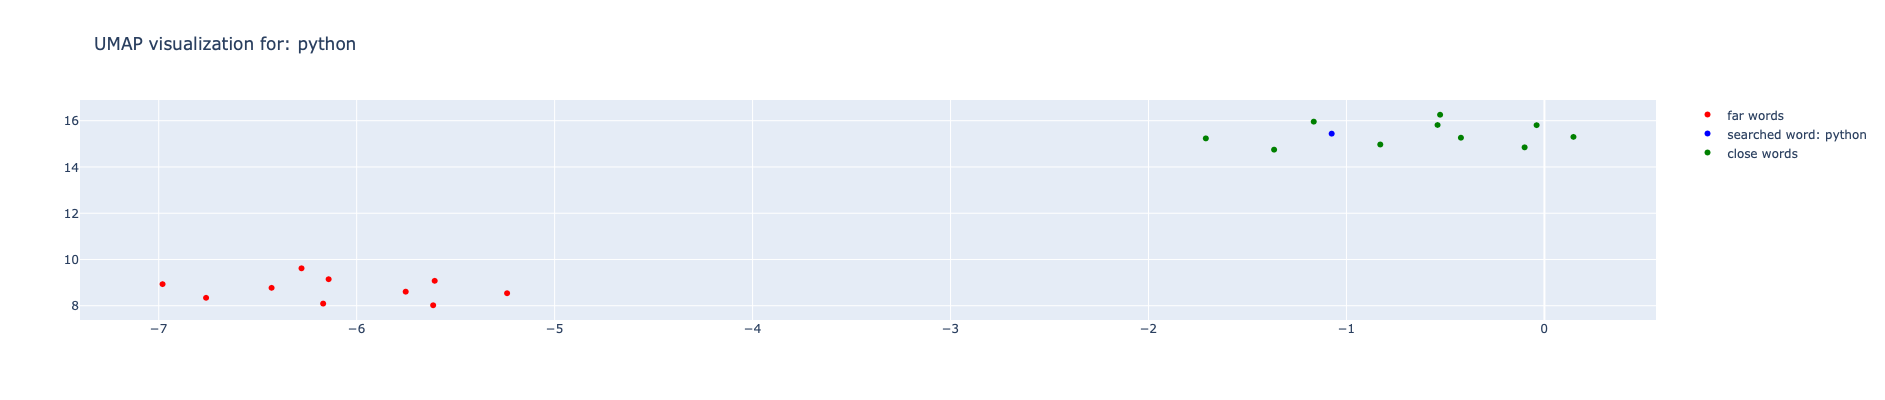

In [48]:
# Plots 10 closest word (blue) and the 11th- 20th closest words (green)
umapscatterplot(w2v_model, "python", [t[0] for t in w2v_model.wv.most_similar(positive=["python"], topn=20)][10:])

# Plots 10 closest word (blue) and the 10 most distant words (green)
umapscatterplot(w2v_model, 'python', [i[0] for i in w2v_model.wv.most_similar(negative=["python"])])